# Loading the Data

In [1]:
import pandas as pd
from google.colab import drive
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, BertModel, AdamW
from sklearn.model_selection import train_test_split
from torchvision import transforms
from tqdm import tqdm
import os
import numpy as np
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader,Dataset, TensorDataset

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp '/content/drive/MyDrive/train.csv' train.csv
!cp '/content/drive/MyDrive/trainImages.zip' trainImages.zip
! unzip -q trainImages.zip
!cp '/content/drive/MyDrive/val.csv' val.csv
!cp '/content/drive/MyDrive/valImages.zip' valImages.zip
! unzip -q valImages.zip
!cp '/content/drive/MyDrive/test.csv' test.csv
!cp '/content/drive/MyDrive/testImages.zip' testImages.zip
! unzip -q testImages.zip

replace __MACOSX/._trainImages? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
replace valImages/802.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [6]:
df_train = pd.read_csv('train.csv')
df_train.head()

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,not_offensive,not_motivational,neutral,Relationship status.\nSingle\nMarried\nIt's co...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,twisted_meaning,slight,not_motivational,neutral,Bernie or REAGAN?\nBe informed. Compare them o...
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,not_offensive,not_motivational,positive,I HEAR SOMETHING\nBetter run a mile\nOMG RAJ?\...
3,3,https://preview.redd.it/iwcz3o2niix61.jpg?widt...,very_funny,twisted_meaning,not_offensive,not_motivational,positive,Redditors Visiting IG memepages\n*dies from cr...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,not_funny,not_sarcastic,very_offensive,not_motivational,negative,"Samajh nahi aaya Par sun ke acabo,\nBUDGET SPE..."


In [7]:
df_val = pd.read_csv('val.csv', delimiter='\t')
df_val.head()

,Unnamed: 0,image_url,humour,sarcastic,offensive,motivational,overall,ocr
0,0,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,twisted_meaning,not_offensive,not_motivational,neutral,RVCJ\nwww.EVCI.COM\nTum paas aaye yun muskuray...
1,1,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,negative,"rukjao Maqbeol,\nbabuji ko tum nalt muaracay-\..."
2,2,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,very_negative,champak appreciating Jetha\nfor following lock...
3,3,https://encrypted-tbn0.gstatic.com/images?q=tb...,funny,general,slight,not_motivational,negative,Noor Malik@ItsNoor 22h\nWhen you realize k\nNa...
4,4,https://encrypted-tbn0.gstatic.com/images?q=tb...,very_funny,general,slight,not_motivational,neutral,noop\nαποταθεωρία\nNehe: ita gis having 5 boyf...


In [8]:
df_train.drop(columns=['overall','image_url'], inplace=True)
cat_replace = {'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious': 1}
df_train['humour'] = df_train['humour'].replace(cat_replace)
cat_replace = {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 1, 'very_twisted': 1}
df_train['sarcastic'] = df_train['sarcastic'].replace(cat_replace)
cat_replace = {'not_offensive': 0, 'slight': 1, 'very_offensive': 1, 'hateful_offensive': 1}
df_train['offensive'] = df_train['offensive'].replace(cat_replace)
cat_replace = {'not_motivational': 0, 'motivational': 1}
df_train['motivational'] = df_train['motivational'].replace(cat_replace)

df_val.drop(columns=['overall','image_url'], inplace=True)
cat_replace = {'not_funny': 0, 'funny': 1, 'very_funny': 1, 'hilarious': 1}
df_val['humour'] = df_val['humour'].replace(cat_replace)
cat_replace = {'not_sarcastic': 0, 'general': 1, 'twisted_meaning': 1, 'very_twisted': 1}
df_val['sarcastic'] = df_val['sarcastic'].replace(cat_replace)
cat_replace = {'not_offensive': 0, 'slight': 1, 'very_offensive': 1, 'hateful_offensive': 1}
df_val['offensive'] = df_val['offensive'].replace(cat_replace)
cat_replace = {'not_motivational': 0, 'motivational': 1}
df_val['motivational'] = df_val['motivational'].replace(cat_replace)

In [9]:
def balance_classes(df, column):
    df_class_0 = df[df[column] == 0]
    df_class_1 = df[df[column] == 1]
    minority_class = 0 if len(df_class_0) < len(df_class_1) else 1
    majority_class = 1 - minority_class
    df_minority = df[df[column] == minority_class]
    df_majority = df[df[column] == majority_class]

    df_majority_undersampled = df_majority.sample(len(df_minority), random_state=42)
    df_balanced = pd.concat([df_minority, df_majority_undersampled])
    return df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

categories = ['humour', 'sarcastic', 'offensive', 'motivational']
for category in categories:
    df_train = balance_classes(df_train, category)
    df_val = balance_classes(df_val, category)

In [10]:
y_train = df_train.iloc[:,1:5]
y_val = df_val.iloc[:,1:5]

In [11]:
y_train = torch.tensor(np.array(y_train))
y_val = torch.tensor(np.array(y_val))

# Loading the BERT and ViT Models for Embedding

In [12]:
# Extract captions and labels
train_captions = df_train['ocr'].tolist()
val_captions = df_val['ocr'].tolist()

# Tokenizer
tokenizer = BertTokenizer.from_pretrained('nirantk/hinglish-bert')
max_len = 500  # or another appropriate length

# Load pre-trained BERT
BERT_model = BertModel.from_pretrained('nirantk/hinglish-bert')

# Training settings
BERT_model.to(device)
optimizer = AdamW(BERT_model.parameters(), lr=2e-5)

tokenizer_config.json:   0%|          | 0.00/152 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.22k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [13]:
ViT_feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
ViT_model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
ViT_model.to(device)

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/346M [00:00<?, ?B/s]

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class AttentionBasedCombiner(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(AttentionBasedCombiner, self).__init__()
        self.attention = nn.Linear(input_size, 1)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, embeddings, pooled_output):
        concatenated = torch.cat((embeddings, pooled_output), dim=1)
        attention_weights = torch.sigmoid(self.attention(concatenated))
        attended = concatenated * attention_weights
        x = F.relu(self.fc1(attended))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# Model instantiation
model = AttentionBasedCombiner(input_size=1536, hidden_size=512, output_size=1).to(device)

# Implementing Concatenation for Combining Data

In [15]:
BERT_model.eval()
ViT_model.eval()

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUActivation(

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CombinedAttentionModel(nn.Module):
    def __init__(self, embedding_dim):
        super(CombinedAttentionModel, self).__init__()
        self.attention_layer = nn.Linear(2 * embedding_dim, 1)

    def forward(self, embedding1, embedding2):
        combined = torch.cat((embedding1, embedding2), dim=1)
        attention_weights = torch.sigmoid(self.attention_layer(combined))
        attended_embedding1 = attention_weights * embedding1
        attended_embedding2 = attention_weights * embedding2
        combined_embedding = attended_embedding1 + attended_embedding2
        return combined_embedding

In [17]:
attention = CombinedAttentionModel(768).to(device)

In [18]:
# Combine Embeddings for Training Set
training_attention = []
batch_size = 1

for i in range(0, len(train_captions), batch_size):
  if i % 100 == 0:
    print(i)
  i_end = min(i + batch_size, len(train_captions))
  input_text = train_captions[i:i_end]
  inputs = tokenizer.encode_plus(
      input_text,
      add_special_tokens=True,
      max_length=500,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt'
  ).to(device)


  with torch.no_grad():
    outputs = BERT_model(**inputs)
    hidden_states = outputs.last_hidden_state
  embeddings = hidden_states[:, 1:-1, :].mean(dim=1)
  # print(embeddings.shape)

  images = [Image.open(f'/content/trainImages/{j}.jpg') for j in range(i, i_end)]
  inputs = ViT_feature_extractor(images=images, return_tensors="pt").to(device)
  outputs = ViT_model(**inputs)
  pooled_output = outputs.pooler_output

  # print(pooled_output.shape)
  attention_output = attention(embeddings, pooled_output).detach().cpu().numpy()
  training_attention.append(attention_output)
  #print(bilinear_output.shape)
training_attention = np.concatenate(training_attention, axis=0)

0
100
200
300


In [19]:
# Combine Embeddings for Validation Set
val_attention = []
batch_size = 1

for i in range(0, len(val_captions), batch_size):
  i_end = min(i + batch_size, len(val_captions))
  input_text = val_captions[i:i_end]
  inputs = tokenizer.encode_plus(
      input_text,
      add_special_tokens=True,
      max_length=500,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt'
  ).to(device)

  with torch.no_grad():
    outputs = BERT_model(**inputs)
    hidden_states = outputs.last_hidden_state
  embeddings = hidden_states[:, 1:-1, :].mean(dim=1)
  # print(embeddings.shape)

  images = [Image.open(f'/content/trainImages/{j}.jpg') for j in range(i, i_end)]
  inputs = ViT_feature_extractor(images=images, return_tensors="pt").to(device)
  outputs = ViT_model(**inputs)
  pooled_output = outputs.pooler_output

  # print(pooled_output.shape)
  attention_output = attention(embeddings, pooled_output).detach().cpu().numpy()
  val_attention.append(attention_output)
  #print(bilinear_output.shape)
val_attention = np.concatenate(val_attention, axis=0)

# Loading the Data into DataLoader and Creating the MLP Classification Model

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMLP(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, dropout_rate=0.5):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.dropout1 = nn.Dropout(dropout_rate)

        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.fc3 = nn.Linear(hidden_size2, hidden_size2)
        self.bn3 = nn.BatchNorm1d(hidden_size2)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.fc4 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # x = F.relu(self.fc1(x))
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        # x = F.relu(self.fc2(x))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        # x = F.relu(self.fc3(x))
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout3(x)

        x = torch.sigmoid(self.fc4(x))
        return x

In [21]:
train_dataset = TensorDataset(torch.from_numpy(training_attention), y_train)
batch_size = 16
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.from_numpy(val_attention), y_val)
batch_size = 16
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [22]:
input_size = 768
hidden_size1 = 512
hidden_size2 = 256
output_size = 4

model = SimpleMLP(input_size, hidden_size1, hidden_size2, output_size)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training the Model on the Pooled Embeddings

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import f1_score

train_f1_overall = []
train_f1_humor = []
train_f1_sarcasm = []
train_f1_offensive = []
train_f1_motivation = []
train_loss = []

val_f1_overall = []
val_f1_humor = []
val_f1_sarcasm = []
val_f1_offensive = []
val_f1_motivation = []
val_loss = []
model = model.to(device)
num_epochs = 50

for epoch in range(num_epochs):
  model.train()
  for batch_idx, (embeddings, labels) in enumerate(train_dataloader):
      # Forward Pass
      embeddings = embeddings.to(device)
      labels = labels.to(device)
      optimizer.zero_grad()
      predictions = model(embeddings)
      predictions = predictions.squeeze(dim=1)
      loss = criterion(predictions, labels.float())
      # Backward Pass
      loss.backward()
      optimizer.step()
      # Get Training Loss
      train_loss.append(loss.item())

      # Get Overall F1 Score
      predictions_flat = predictions.view(-1)
      predictions_flat = (predictions_flat > 0.5).float()
      labels_flat = labels.view(-1)
      f1_overall = f1_score(labels_flat.detach().cpu().numpy(), predictions_flat.detach().cpu().numpy(), average='binary')
      train_f1_overall.append(f1_overall)
      # Split the predictions and labels into the 4 individual categories: humor, sarcasm, offensive, motivational
      split_predictions = torch.split(predictions, 1, dim=1)
      predictions_humor, predictions_sarcasm, predictions_offensive, predictions_motivation = split_predictions
      split_labels = torch.split(labels, 1, dim=1)
      labels_humor, labels_sarcasm, labels_offensive, labels_motivation = split_labels
      # Get Humor F1 Score
      predictions_humor_flat = predictions_humor.view(-1)
      predictions_humor_flat = (predictions_humor_flat > 0.5).float()
      labels_humor_flat = labels_humor.view(-1)
      f1_humor = f1_score(labels_humor_flat.detach().cpu().numpy(), predictions_humor_flat.detach().cpu().numpy(), average='binary')
      train_f1_humor.append(f1_humor)
      # Get Sarcasm F1 Score
      predictions_sarcasm_flat = predictions_sarcasm.view(-1)
      predictions_sarcasm_flat = (predictions_sarcasm_flat > 0.5).float()
      labels_sarcasm_flat = labels_sarcasm.view(-1)
      f1_sarcasm = f1_score(labels_sarcasm_flat.detach().cpu().numpy(), predictions_sarcasm_flat.detach().cpu().numpy(), average='binary')
      train_f1_sarcasm.append(f1_sarcasm)
      # Get Offensive F1 Score
      predictions_offensive_flat = predictions_offensive.view(-1)
      predictions_offensive_flat = (predictions_offensive_flat > 0.5).float()
      labels_offensive_flat = labels_offensive.view(-1)
      f1_offensive = f1_score(labels_offensive_flat.detach().cpu().numpy(), predictions_offensive_flat.detach().cpu().numpy(), average='binary')
      train_f1_offensive.append(f1_offensive)
      # Get Motivational F1 Score
      predictions_motivation_flat = predictions_motivation.view(-1)
      predictions_motivation_flat = (predictions_motivation_flat > 0.5).float()
      labels_motivation_flat = labels_motivation.view(-1)
      f1_motivation = f1_score(labels_motivation_flat.detach().cpu().numpy(), predictions_motivation_flat.detach().cpu().numpy(), average='binary', zero_division=0)
      train_f1_motivation.append(f1_motivation)


      if(batch_idx % 10 == 0):
        print(f"Epoch {epoch + 1}, Batch {batch_idx + 1}, F1 Score: {f1_overall:.4f}, Loss: {loss.item()}")
  # Run validation after each epoch
  model.eval()
  val_f1_overall_epoch = []
  val_f1_humor_epoch = []
  val_f1_sarcasm_epoch = []
  val_f1_offensive_epoch = []
  val_f1_motivation_epoch = []
  val_loss_epoch = []
  for val_batch_idx, (val_embeddings, val_labels) in enumerate(val_dataloader):
    # Make predictions on validation set
    val_embeddings = val_embeddings.to(device)
    val_labels = val_labels.to(device)
    val_predictions = model(val_embeddings)
    val_predictions_flat = val_predictions.view(-1)
    val_predictions_flat = (val_predictions_flat > 0.5).float()
    val_labels_flat = val_labels.view(-1)
    # Get Overall F1 Score
    val_f1_batch = f1_score(val_labels_flat.detach().cpu().numpy(), val_predictions_flat.detach().cpu().numpy(), average='binary')
    val_f1_overall_epoch.append(val_f1_batch)
    # Get Training Loss
    val_loss_batch = criterion(val_predictions, val_labels.float()).detach().cpu().numpy()
    val_loss_epoch.append(val_loss_batch)
    # Split the predictions and labels into the 4 individual categories: humor, sarcasm, offensive, motivational
    split_predictions = torch.split(val_predictions, 1, dim=1)
    predictions_humor, predictions_sarcasm, predictions_offensive, predictions_motivation = split_predictions
    split_labels = torch.split(val_labels, 1, dim=1)
    labels_humor, labels_sarcasm, labels_offensive, labels_motivation = split_labels
    # Get Humor F1 Score
    predictions_humor_flat = predictions_humor.view(-1)
    predictions_humor_flat = (predictions_humor_flat > 0.5).float()
    labels_humor_flat = labels_humor.view(-1)
    f1_humor = f1_score(labels_humor_flat.detach().cpu().numpy(), predictions_humor_flat.detach().cpu().numpy(), average='binary')
    val_f1_humor_epoch.append(f1_humor)
    # Get Sarcasm F1 Score
    predictions_sarcasm_flat = predictions_sarcasm.view(-1)
    predictions_sarcasm_flat = (predictions_sarcasm_flat > 0.5).float()
    print(predictions_sarcasm_flat)
    labels_sarcasm_flat = labels_sarcasm.view(-1)
    f1_sarcasm = f1_score(labels_sarcasm_flat.detach().cpu().numpy(), predictions_sarcasm_flat.detach().cpu().numpy(), average='binary')
    val_f1_sarcasm_epoch.append(f1_sarcasm)
    # Get Offensive F1 Score
    predictions_offensive_flat = predictions_offensive.view(-1)
    predictions_offensive_flat = (predictions_offensive_flat > 0.5).float()
    labels_offensive_flat = labels_offensive.view(-1)
    f1_offensive = f1_score(labels_offensive_flat.detach().cpu().numpy(), predictions_offensive_flat.detach().cpu().numpy(), average='binary')
    val_f1_offensive_epoch.append(f1_offensive)
    # Get Motivation F1 Score
    predictions_motivation_flat = predictions_motivation.view(-1)
    predictions_motivation_flat = (predictions_motivation_flat > 0.5).float()
    labels_motivation_flat = labels_motivation.view(-1)
    f1_motivation = f1_score(labels_motivation_flat.detach().cpu().numpy(), predictions_motivation_flat.detach().cpu().numpy(), average='binary',zero_division=0)
    val_f1_motivation_epoch.append(f1_motivation)

  val_loss.append(np.mean(val_loss_epoch))
  val_f1_overall.append(np.mean(val_f1_overall_epoch))

  val_f1_humor.append(np.mean(val_f1_humor_epoch))
  val_f1_sarcasm.append(np.mean(val_f1_sarcasm_epoch))
  val_f1_offensive.append(np.mean(val_f1_offensive_epoch))
  val_f1_motivation.append(np.mean(val_f1_motivation_epoch))

  print(f"Epoch {epoch + 1}, Average Validation F1 Score: {np.mean(val_f1_overall_epoch):.4f}")

Epoch 1, Batch 1, F1 Score: 0.4918, Loss: 0.7159707546234131
Epoch 1, Batch 11, F1 Score: 0.3793, Loss: 0.7642551064491272
Epoch 1, Batch 21, F1 Score: 0.5714, Loss: 0.695010781288147
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       device='cuda:0')
Epoch 1, Average Validation F1 Score: 0.3500
Epoch 2, Batch 1, F1 Score: 0.4727, Loss: 0.698928713798523
Epoch 2, Batch 11, F1 Score: 0.4286, Loss: 0.7626559138298035
Epoch 2, Batch 21, F1 Score: 0.5758, Loss: 0.6646783351898193
tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       device='cuda:0')
Epoch 2, Average Validation F1 Score: 0.4444
Epoch 3, Batch 1, F1 Score: 0.4906, Loss: 0.6895573139190674
Epoch 3, Batch 11, F1 Score: 0.5231, Loss: 0.7034189105033875
Epoch 3, Batch 21, F1 Score: 0.5085, Loss: 0.6955060958862305
tensor([0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0.],
       device='cuda:0')
Epoch 3, Average Validation F1 Score: 0.3256
Epoch 4, Batch 1, F1 Score: 0.4912, Loss: 0.7

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 1.],
       device='cuda:0')
Epoch 34, Average Validation F1 Score: 0.5909
Epoch 35, Batch 1, F1 Score: 0.7333, Loss: 0.4913341999053955
Epoch 35, Batch 11, F1 Score: 0.6909, Loss: 0.551814615726471
Epoch 35, Batch 21, F1 Score: 0.6531, Loss: 0.4950354993343353
tensor([0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0.],
       device='cuda:0')
Epoch 35, Average Validation F1 Score: 0.6383
Epoch 36, Batch 1, F1 Score: 0.6522, Loss: 0.46146294474601746
Epoch 36, Batch 11, F1 Score: 0.7917, Loss: 0.43125495314598083
Epoch 36, Batch 21, F1 Score: 0.7857, Loss: 0.4952566623687744
tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1.],
       device='cuda:0')
Epoch 36, Average Validation F1 Score: 0.5455
Epoch 37, Batch 1, F1 Score: 0.6786, Loss: 0.5054445266723633
Epoch 37, Batch 11, F1 Score: 0.8136, Loss: 0.4505520462989807
Epoch 37, Batch 21, F1 Score: 0.9286, Loss: 0.41583865880966187
tensor([0., 0., 0., 1., 1., 1

# Plotting the Data

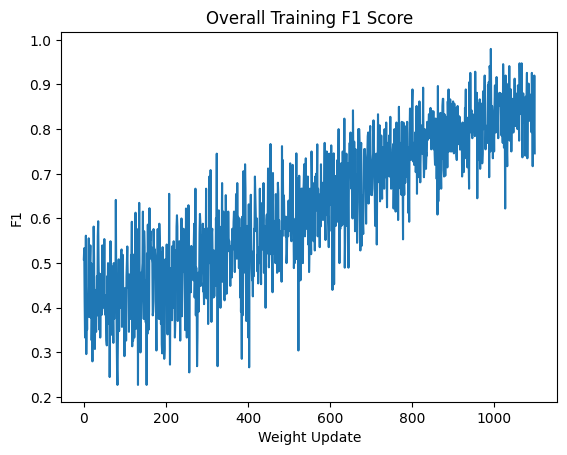

In [ ]:
import matplotlib .pyplot as plt

plt.plot(np.array(range(len(train_f1_overall))), train_f1_overall)
plt.title('Overall Training F1 Score')
plt.xlabel('Weight Update')
plt.ylabel('F1')
plt.show()

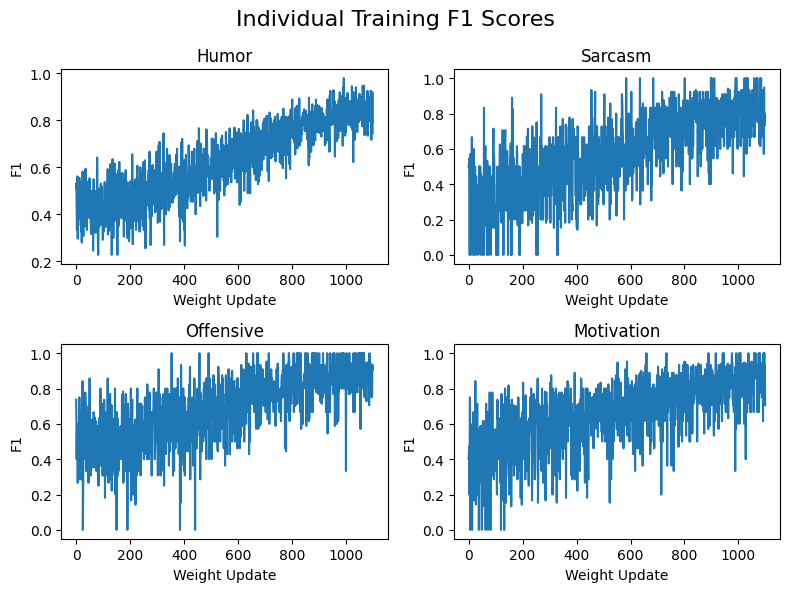

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Individual Training F1 Scores', fontsize=16)

axs[0, 0].plot(np.array(range(len(train_f1_humor))), train_f1_overall, label='Humor')
axs[0, 0].set_title('Humor')
axs[0, 0].set_xlabel('Weight Update')
axs[0, 0].set_ylabel('F1')

axs[0, 1].plot(np.array(range(len(train_f1_sarcasm))), train_f1_sarcasm, label='Sarcasm')
axs[0, 1].set_title('Sarcasm')
axs[0, 1].set_xlabel('Weight Update')
axs[0, 1].set_ylabel('F1')

axs[1, 0].plot(np.array(range(len(train_f1_offensive))), train_f1_offensive, label='Offensive')
axs[1, 0].set_title('Offensive')
axs[1, 0].set_xlabel('Weight Update')
axs[1, 0].set_ylabel('F1')

axs[1, 1].plot(np.array(range(len(train_f1_motivation))), train_f1_motivation, label='Motivation')
axs[1, 1].set_title('Motivation')
axs[1, 1].set_xlabel('Weight Update')
axs[1, 1].set_ylabel('F1')

plt.tight_layout()

# Show the plot
plt.show()

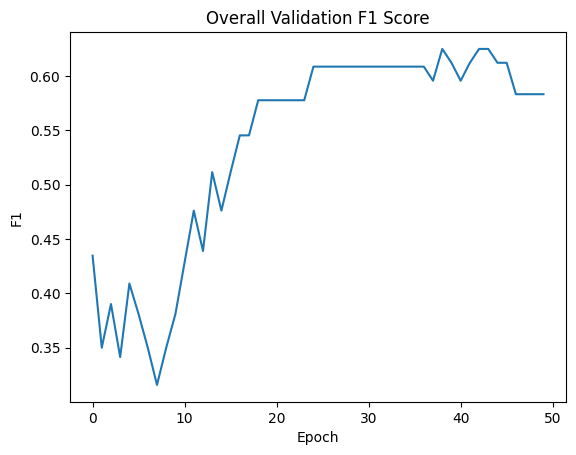

In [ ]:
plt.plot(np.array(range(len(val_f1_overall))), val_f1_overall)
plt.title('Overall Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1')
plt.show()

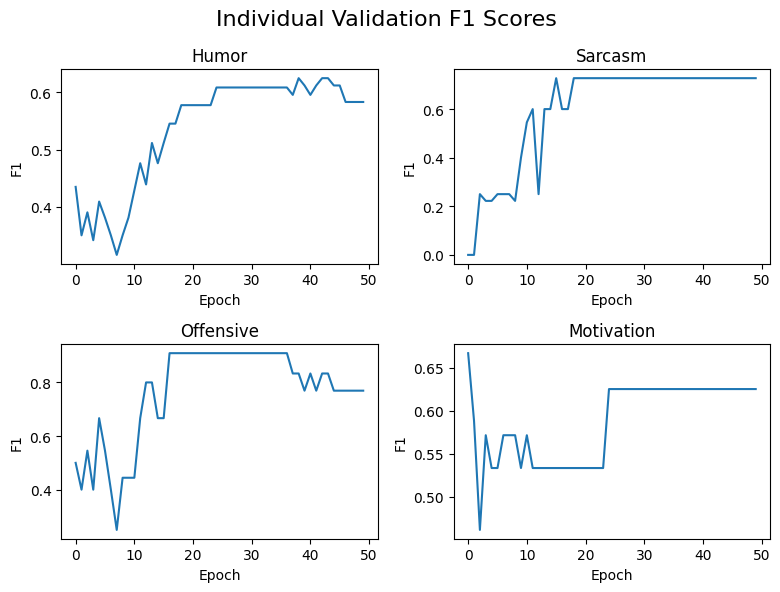

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
fig.suptitle('Individual Validation F1 Scores', fontsize=16)

axs[0, 0].plot(np.array(range(len(val_f1_humor))), val_f1_overall, label='Humor')
axs[0, 0].set_title('Humor')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('F1')

axs[0, 1].plot(np.array(range(len(val_f1_sarcasm))), val_f1_sarcasm, label='Sarcasm')
axs[0, 1].set_title('Sarcasm')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('F1')

axs[1, 0].plot(np.array(range(len(val_f1_offensive))), val_f1_offensive, label='Offensive')
axs[1, 0].set_title('Offensive')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('F1')

axs[1, 1].plot(np.array(range(len(val_f1_motivation))), val_f1_motivation, label='Motivation')
axs[1, 1].set_title('Motivation')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('F1')

plt.tight_layout()

# Show the plot
plt.show()

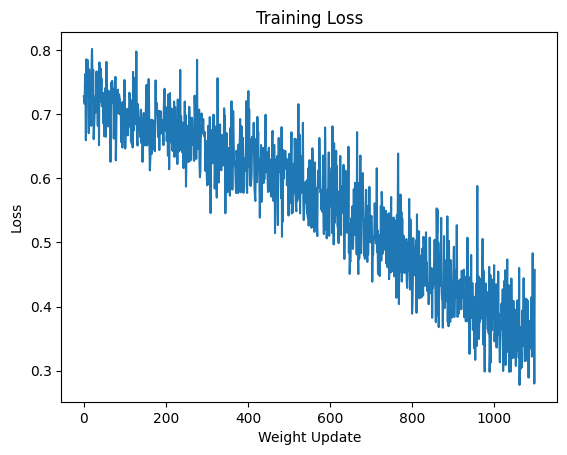

In [ ]:
plt.plot(np.array(range(len(train_loss))), train_loss)
plt.title('Training Loss')
plt.xlabel('Weight Update')
plt.ylabel('Loss')
plt.show()

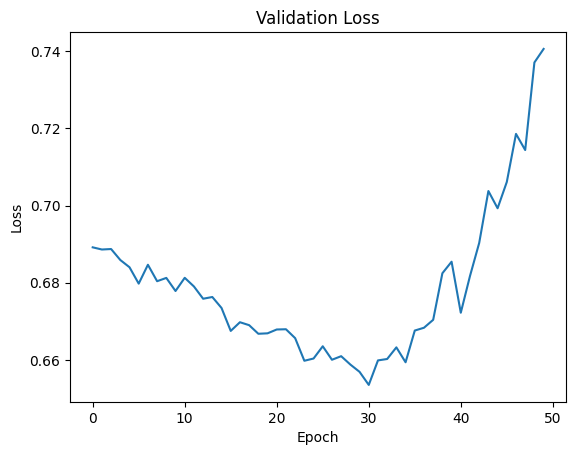

In [ ]:
plt.plot(np.array(range(len(val_loss))), val_loss)
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [25]:
df_test = pd.read_csv('test.csv')

test_caption = df_test['ocr'].tolist()
input_text = test_caption[13]
inputs = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    max_length=500,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
).to(device)

with torch.no_grad():
  outputs = BERT_model(**inputs)
  hidden_states = outputs.last_hidden_state
embeddings = hidden_states[:, 1:-1, :].mean(dim=1)
# print(embeddings.shape)

images = Image.open(f'/content/testImages/{16}.jpg')
inputs = ViT_feature_extractor(images=images, return_tensors="pt").to(device)
outputs = ViT_model(**inputs)
pooled_output = outputs.pooler_output

attention_output = attention(embeddings, pooled_output)
test_embeddings = torch.tensor(attention_output.detach().cpu().numpy())
test_embeddings = test_embeddings.to(device)
test_predictions = model(test_embeddings)
test_predictions = (test_predictions > 0.5).float()
print(test_predictions)

tensor([[1., 1., 0., 0.]], device='cuda:0')


In [26]:
input_text = val_captions[12]
inputs = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    max_length=500,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
).to(device)

with torch.no_grad():
  outputs = BERT_model(**inputs)
  hidden_states = outputs.last_hidden_state
embeddings = hidden_states[:, 1:-1, :].mean(dim=1)
# print(embeddings.shape)

images = Image.open(f'/content/valImages/{12}.jpg')
inputs = ViT_feature_extractor(images=images, return_tensors="pt").to(device)
outputs = ViT_model(**inputs)
pooled_output = outputs.pooler_output

attention_output = attention(embeddings, pooled_output)
test_embeddings = torch.tensor(attention_output.detach().cpu().numpy())
test_embeddings = test_embeddings.to(device)
test_predictions = model(test_embeddings)
test_predictions = (test_predictions > 0.5).float()
print(test_predictions)
print(y_val[12])

tensor([[0., 0., 1., 1.]], device='cuda:0')
tensor([0, 1, 1, 1])


In [27]:
input_text = train_captions[34]
inputs = tokenizer.encode_plus(
    input_text,
    add_special_tokens=True,
    max_length=500,
    padding='max_length',
    return_attention_mask=True,
    return_tensors='pt'
).to(device)

with torch.no_grad():
  outputs = BERT_model(**inputs)
  hidden_states = outputs.last_hidden_state
embeddings = hidden_states[:, 1:-1, :].mean(dim=1)
# print(embeddings.shape)

images = Image.open(f'/content/trainImages/{34}.jpg')
inputs = ViT_feature_extractor(images=images, return_tensors="pt").to(device)
outputs = ViT_model(**inputs)
pooled_output = outputs.pooler_output

attention_output = attention(embeddings, pooled_output)
test_embeddings = torch.tensor(attention_output.detach().cpu().numpy())
test_embeddings = test_embeddings.to(device)
test_predictions = model(test_embeddings)
test_predictions = (test_predictions > 0.5).float()
print(test_predictions)
print(y_train[34])

tensor([[1., 1., 1., 1.]], device='cuda:0')
tensor([1, 1, 1, 1])
